# Biodiversity in National Parks

## Goals and Scope 

The data for this study consists of:
- `observations.csv` holds recorded sightings of different species at several national parks for the past 7 days.

- `species_info.csv` contains data about different species and their conservation status.

We answer the following questions:
1. How is the distribution of species in the different national parks?
2. Is any specific category of species more endangered than others?
3. Are the populations of endangered species the same in all National Parks, are there any patterns?
4. Are the number of observations for a given species proportional to the total number of observations for that park or is there variability. 
5. Which species are the most/least abundant in every national park, do they follow their conservation status?



In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

sns.set_theme()

## Load and clean data

In [3]:
observations = pd.read_csv("observations.csv")
species = pd.read_csv("species_info.csv")

In [4]:
observations.head(10)

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85
5,Elymus virginicus var. virginicus,Yosemite National Park,112
6,Spizella pusilla,Yellowstone National Park,228
7,Elymus multisetus,Great Smoky Mountains National Park,39
8,Lysimachia quadrifolia,Yosemite National Park,168
9,Diphyscium cumberlandianum,Yellowstone National Park,250


In [5]:
species.head(10)

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN
5,Mammal,Odocoileus virginianus,White-Tailed Deer,NaN
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",NaN
7,Mammal,Canis latrans,Coyote,Species of Concern
8,Mammal,Canis lupus,Gray Wolf,Endangered
9,Mammal,Canis rufus,Red Wolf,Endangered


In [6]:
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


In [7]:
species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


##### Eliminating duplicates from species

According to https://en.wikipedia.org/wiki/IUCN_Red_List the ranking of conservation status is:
1. Extinct (EX) – No known living individuals
2. Extinct in the wild (EW) – Known only to survive in captivity, or as a naturalized population outside its historic range
3. Critically Endangered (CR) – Highest risk of extinction in the wild
4. Endangered (EN) – Higher risk of extinction in the wild
5. Vulnerable (VU) – High risk of extinction in the wild
6. Near Threatened (NT) – Likely to become endangered in the near future
7. Conservation Dependent (CD) – Low risk; is conserved to prevent being near threatened, certain events may lead it to being a higher risk level
8. Least concern (LC) – Very Low risk; does not qualify for a higher risk category and not likely to be threatened in the near future. Widespread and abundant taxa are included in this category.
9. Data deficient (DD) – Not enough data to make an assessment of its risk of extinction
10. Not evaluated (NE) – Has not yet been evaluated against the criteria.

we will introduce a ranking for the data frame of species inspired in the above and label them as "Not in danger" if there is no data available.

In [8]:
species['conservation_status'] = species.conservation_status.apply(lambda x: x if( str(x) != 'nan' ) else 'Not in danger')
cat_type = pd.api.types.CategoricalDtype(categories=['Not in danger', 'Species of Concern', 'In Recovery', 'Threatened', 'Endangered'], ordered=True)
species = species.astype({'conservation_status': cat_type})
species

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Not in danger
1,Mammal,Bos bison,"American Bison, Bison",Not in danger
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",Not in danger
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",Not in danger
4,Mammal,Cervus elaphus,Wapiti Or Elk,Not in danger
...,...,...,...,...
5819,Vascular Plant,Solanum parishii,Parish's Nightshade,Not in danger
5820,Vascular Plant,Solanum xanti,"Chaparral Nightshade, Purple Nightshade",Not in danger
5821,Vascular Plant,Parthenocissus vitacea,"Thicket Creeper, Virginia Creeper, Woodbine",Not in danger
5822,Vascular Plant,Vitis californica,"California Grape, California Wild Grape",Not in danger


We eliminate duplicates first, based on category and scientific name, we drop the information of the common name in the process.

Then for still duplicated scientific names with different conservation status we choose the highest ranked entry.

In [9]:
species = species.drop_duplicates(subset=['category','scientific_name','conservation_status'])
species_clean = species.groupby(['scientific_name','category']).conservation_status.max().reset_index()
print(species_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5541 entries, 0 to 5540
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   scientific_name      5541 non-null   object  
 1   category             5541 non-null   object  
 2   conservation_status  5541 non-null   category
dtypes: category(1), object(2)
memory usage: 92.3+ KB
None


##### Eliminating duplicates from observations

Some parks have several entries for observations for the same species, we only know that the data was taken within seven days, but we cannot deduce any time information. Therefore, we opt to consider the average number of observations for such species.

In [10]:
observations_clean = observations.groupby(['scientific_name','park_name']).observations.mean().reset_index()
observations_clean = observations_clean.astype({'observations':'int64'})

In [11]:
data_nps = pd.merge(observations_clean, species_clean, how='left')
data_nps.head(10)

,scientific_name,park_name,observations,category,conservation_status
0,Abies bifolia,Bryce National Park,109,Vascular Plant,Not in danger
1,Abies bifolia,Great Smoky Mountains National Park,72,Vascular Plant,Not in danger
2,Abies bifolia,Yellowstone National Park,215,Vascular Plant,Not in danger
3,Abies bifolia,Yosemite National Park,136,Vascular Plant,Not in danger
4,Abies concolor,Bryce National Park,83,Vascular Plant,Not in danger
5,Abies concolor,Great Smoky Mountains National Park,101,Vascular Plant,Not in danger
6,Abies concolor,Yellowstone National Park,241,Vascular Plant,Not in danger
7,Abies concolor,Yosemite National Park,205,Vascular Plant,Not in danger
8,Abies fraseri,Bryce National Park,109,Vascular Plant,Species of Concern
9,Abies fraseri,Great Smoky Mountains National Park,81,Vascular Plant,Species of Concern


In [12]:
print(data_nps.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22164 entries, 0 to 22163
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   scientific_name      22164 non-null  object  
 1   park_name            22164 non-null  object  
 2   observations         22164 non-null  int64   
 3   category             22164 non-null  object  
 4   conservation_status  22164 non-null  category
dtypes: category(1), int64(1), object(3)
memory usage: 714.6+ KB
None


## Verifying data is clean

In [13]:
print('Observations were classified in ' + str(data_nps.category.nunique()) + ' categories, listed below:')
print(data_nps.category.unique())

print('Observations were made in ' + str(data_nps.park_name.nunique()) + ' National parks, listed below:')
print(list(data_nps.park_name.unique()))

print('Observations have ' + str(data_nps.conservation_status.nunique()) + ' conservation status possibilities, listed below:')
print(list(data_nps.conservation_status.unique()))


Observations were classified in 7 categories, listed below:
['Vascular Plant' 'Nonvascular Plant' 'Bird' 'Amphibian' 'Reptile'
 'Mammal' 'Fish']
Observations were made in 4 National parks, listed below:
['Bryce National Park', 'Great Smoky Mountains National Park', 'Yellowstone National Park', 'Yosemite National Park']
Observations have 5 conservation status possibilities, listed below:
['Not in danger', 'Species of Concern', 'Threatened', 'Endangered', 'In Recovery']


In [14]:
data_nulls = data_nps[data_nps.conservation_status.isnull()]
print(len(data_nulls))

data_dups = data_nps.duplicated(subset=['scientific_name','category','park_name'])
data_dups.unique()


0


array([False])

The `observations` file had several observations in a given park for a species with the same scientific name and the `species_info` had entries with duplicates in the scientific name with differing conservation status. After cleaning the individual data frames, we have merged the data sets and created one single clean data frame free of missing data or duplicates.

We create a column with shorter names of the national parks to help with plotting later on.

In [15]:
data_nps['park_name_short'] = data_nps.park_name.apply(lambda x: str(x).replace(' National Park',''))
data_nps['park_name_short'] = data_nps.park_name_short.apply(lambda x: str(x).replace('Mountains','Mts.'))

In [16]:
data_nps

,scientific_name,park_name,observations,category,conservation_status,park_name_short
0,Abies bifolia,Bryce National Park,109,Vascular Plant,Not in danger,Bryce
1,Abies bifolia,Great Smoky Mountains National Park,72,Vascular Plant,Not in danger,Great Smoky Mts.
2,Abies bifolia,Yellowstone National Park,215,Vascular Plant,Not in danger,Yellowstone
3,Abies bifolia,Yosemite National Park,136,Vascular Plant,Not in danger,Yosemite
4,Abies concolor,Bryce National Park,83,Vascular Plant,Not in danger,Bryce
...,...,...,...,...,...,...
22159,Zygodon viridissimus,Yosemite National Park,159,Nonvascular Plant,Not in danger,Yosemite
22160,Zygodon viridissimus var. rupestris,Bryce National Park,102,Nonvascular Plant,Not in danger,Bryce
22161,Zygodon viridissimus var. rupestris,Great Smoky Mountains National Park,102,Nonvascular Plant,Not in danger,Great Smoky Mts.
22162,Zygodon viridissimus var. rupestris,Yellowstone National Park,237,Nonvascular Plant,Not in danger,Yellowstone


## Data Summary

The data contains the observations for different species made in 4 different National Parks in the US.

In [17]:
for park in data_nps.park_name.unique():
    print(park)

Bryce National Park
Great Smoky Mountains National Park
Yellowstone National Park
Yosemite National Park


In [18]:
print('There has been ' + str(data_nps.scientific_name.nunique()) + ' different species observed.')

There has been 5541 different species observed.


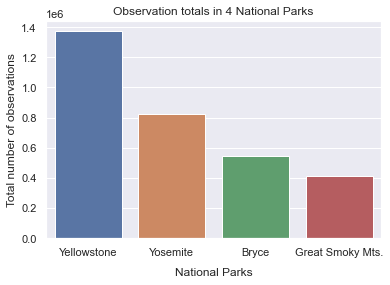

<Figure size 432x288 with 0 Axes>

In [19]:
data_by_park = data_nps.groupby(['park_name_short']).observations.sum().reset_index()
sns.barplot(data=data_by_park,x='park_name_short',y='observations', order=['Yellowstone', 'Yosemite', 'Bryce', 'Great Smoky Mts.'])
plt.xlabel('National Parks', labelpad=10)
plt.ylabel('Total number of observations')
plt.title('Observation totals in 4 National Parks')
plt.show()
plt.clf()

In [20]:
data_nps.groupby(['park_name','category']).describe()

observations   
                                                             count   
park_name                           category                         
Bryce National Park                 Amphibian                 79.0  \
                                    Bird                     488.0   
                                    Fish                     125.0   
                                    Mammal                   176.0   
                                    Nonvascular Plant        333.0   
                                    Reptile                   78.0   
                                    Vascular Plant          4262.0   
Great Smoky Mountains National Park Amphibian                 79.0   
                                    Bird                     488.0   
                                    Fish                     125.0   
                                    Mammal                   176.0   
                                    Nonvascular Plant        333.0   
                                    Reptile                   78.0   
                                    Vascular Plant          4262.0   
Yellowstone National Park           Amphibian                 79.0   
                                    Bird                     488.0   
                                    Fish                     125.0   
                                    Mammal                   176.0   
                                    Nonvascular Plant        333.0   
                                    Reptile                   78.0   
                                    Vascular Plant          4262.0   
Yosemite National Park              Amphibian                 79.0   
                                    Bird                     488.0   
                                    Fish                     125.0   
                                    Mammal                   176.0   
                                    Nonvascular Plant        333.0   
                                    Reptile                   78.0   
                                    Vascular Plant          4262.0   

                                                                               
                                                             mean        std   
park_name                           category                                   
Bryce National Park                 Amphibian           92.392405  21.134743  \
                                    Bird                99.145492  20.412113   
                                    Fish                97.784000  23.597288   
                                    Mammal              95.585227  23.694571   
                                    Nonvascular Plant   99.075075  20.391730   
                                    Reptile            100.692308  19.135408   
                                    Vascular Plant      99.151807  20.233469   
Great Smoky Mountains National Park Amphibian           71.164557  21.292487   
                                    Bird                72.315574  21.167049   
                                    Fish                72.544000  21.869298   
                                    Mammal              69.892045  20.380516   
                                    Nonvascular Plant   74.645646  19.583632   
                                    Reptile             72.000000  21.167851   
                                    Vascular Plant      74.629517  19.801989   
Yellowstone National Park           Amphibian          242.924051  35.788829   
                                    Bird               244.299180  28.261333   
                                    Fish               241.048000  40.062624   
                                    Mammal             238.096591  39.735221   
                                    Nonvascular Plant  249.312312  19.862443   
                                    Reptile            247.435897  20.312231   
                                    Vascula

- The number of species observed are displayed by national park and by category. One can observe that the exact same number of species were tracked in the four national parks.
- The average number of observations per category per national park have a similar standard deviation of around 21 observations.
- We observe that in a given national park the average number of observations is almost the same among the different species' categories.

## Exploratory Data Analysis

Additional available information, like the size of each park will allow us to gain more insight and draw some interesting conclusions.

- Yosemite = 3027 km2
- Yellowstone = 8991 km2
- Great Smoky Mts. = 2114 km2
- Bryce = 145.67 km2

(source: https://www.nps.gov/index.htm )



0.8656605739187329
Intercept    417312.935815
size_km2        103.990086
dtype: float64


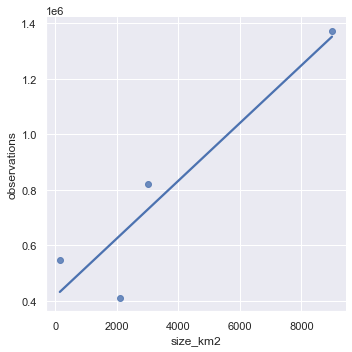

In [21]:
park_sizes = {'Yosemite': 3027, 'Yellowstone': 8991, 'Great Smoky Mts.': 2114, 'Bryce': 145.7}
data_by_park['size_km2'] = data_by_park.apply(lambda row: park_sizes[row.park_name_short], axis=1)
sns.lmplot(data=data_by_park, x='size_km2', y='observations', ci=None)
model = sm.OLS.from_formula('observations ~ size_km2', data = data_by_park)
results = model.fit()
print(results.rsquared)
print(results.params)

We are now in the position to start answering the questions. We will go over the questions posed in the goals and scope section.

### Question 1: How is the distribution of species in the different national parks?

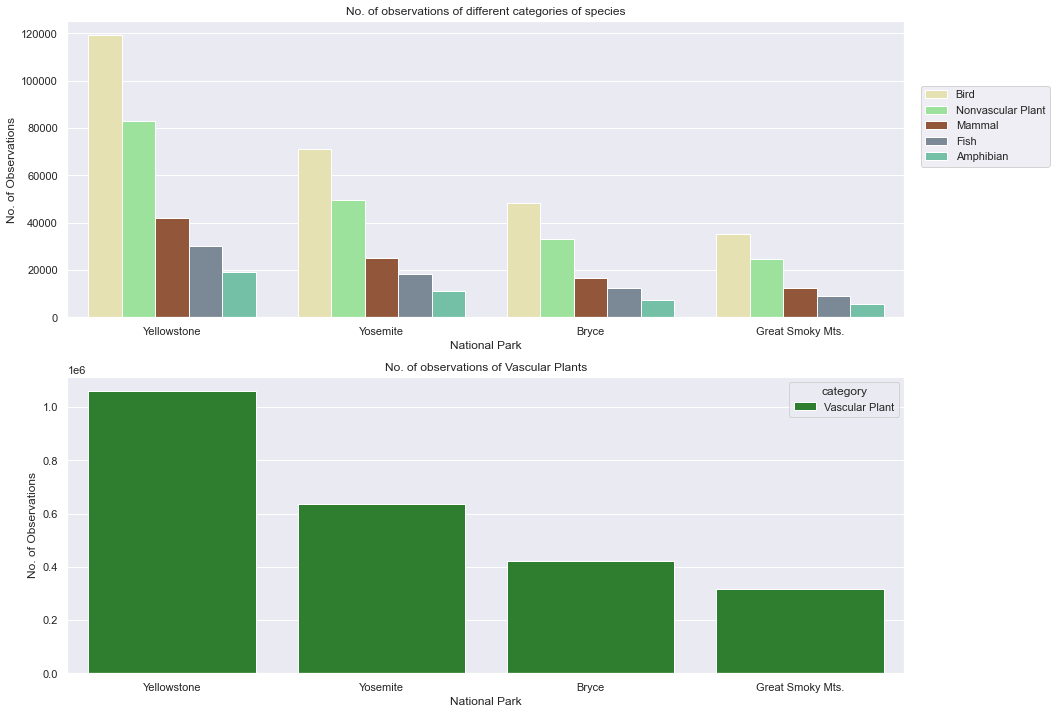

<Figure size 432x288 with 0 Axes>

In [22]:
sum_by_park = data_nps.groupby(['category','park_name_short']).observations.sum().reset_index()
park_list_by_obs = ['Yellowstone','Yosemite','Bryce','Great Smoky Mts.']
bird_color = mcolors.CSS4_COLORS['palegoldenrod']
nonVplant_color = mcolors.CSS4_COLORS['lightgreen']
mammal_color = mcolors.CSS4_COLORS['sienna']
fish_color = mcolors.CSS4_COLORS['lightslategray']
amphibian_color = mcolors.CSS4_COLORS['mediumaquamarine']
vPlant_color = mcolors.CSS4_COLORS['forestgreen']

colors = [bird_color, nonVplant_color, mammal_color,fish_color , amphibian_color]

plt.figure(figsize=(15,12))
# Ignored Vascular plant because numbers are too high compared to other categories.
plt.subplot(2,1,1)
ax = sns.barplot(data=sum_by_park[sum_by_park.category != 'Vascular Plant'],\
            x='park_name_short', y='observations',\
            order=park_list_by_obs,\
            hue='category',\
            hue_order=['Bird','Nonvascular Plant','Mammal','Fish','Amphibian'], palette=colors)
plt.legend(loc='upper right',bbox_to_anchor=(1.18, 0.8));
plt.title("No. of observations of different categories of species")
plt.xlabel('National Park')
plt.ylabel('No. of Observations')

plt.subplot(2,1,2)
sns.barplot(data=sum_by_park[sum_by_park.category == 'Vascular Plant'],x='park_name_short',y='observations',hue='category',palette=[vPlant_color], order=park_list_by_obs)
plt.title("No. of observations of Vascular Plants")
plt.xlabel('National Park', )
plt.ylabel('No. of Observations')

plt.show()
plt.clf()

In [23]:
print(sum_by_park[sum_by_park.category == 'Vascular Plant'].observations.mean())

608985.0


Observations:

- The observations consist primarily of `Vascular Plants` for all national parks, with an average number of observations of 609,000 vascular plants.
- All four parks show the same ranking of categories, where the most observations belong to `Vascular Plants` then `Bird`, followed by `Nonvascular Plant`, `Mammal`, `Fish` and ending with a small number of `Amphibian` in comparison.
- The number of observations is almost proportional to the size of the park, the largest park is Yosemite and has a total of almost 1.4M observations.
- The smallest park is Bryce but has more observations than the second smallest park, the Great Smoky Mts. National park. We could say Bryce is particularly diverse in species compared to its area.
- Yosemite is the second biggest park, it is roughly a third of the size of Yellowstone, but has about half the number of observations of Yellowstone.

### Question 2: Is any specific category of species more endangered than others?

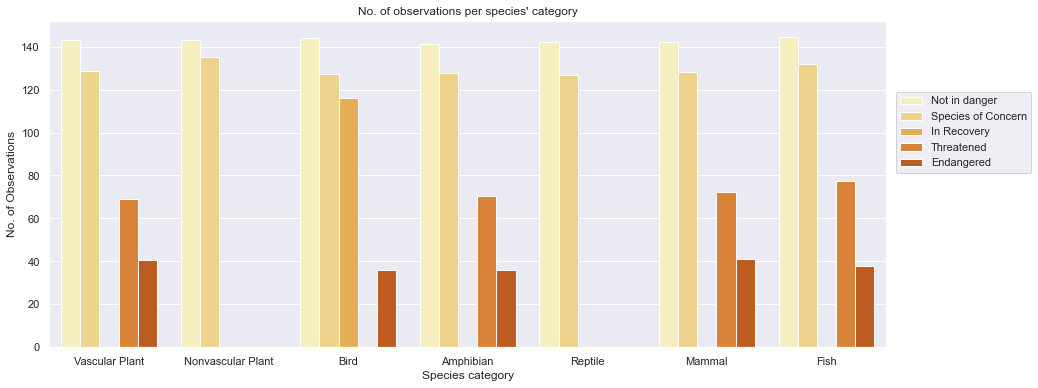

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='category',y='observations',data=data_nps, hue='conservation_status',order=data_nps.category.unique(), errorbar=None, palette=sns.color_palette("YlOrBr"));
ax.set_xticklabels(data_nps.category.unique(),rotation=0)
plt.legend(loc='upper right',bbox_to_anchor=(1.18, 0.8));
plt.title("No. of observations per species' category")
plt.xlabel('Species category', )
plt.ylabel('No. of Observations')
plt.show()
plt.clf()

Observations:

- Across the different species' categories, those that are labeled `Not in danger` have comparable observations, slightly above 140.
- The number of species labeled `Species of concern` comes right after the above with nearly 130 observations in all categories.
- It calls the attention, that only the `Bird` category has observations of species labeled `In recovery` with around 115 observations.
- All categories have around 70 observations of species that are `Threatened` except for `Nonvascular Plant`, `Reptile` and `Bird`.

We look now more closely into the species labeled `Endangered`:



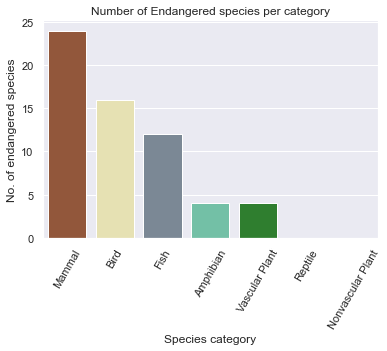

<Figure size 432x288 with 0 Axes>

In [25]:
endangered_df =  data_nps[data_nps.conservation_status == 'Endangered'].groupby(['category']).scientific_name.count().reset_index()
labels = ['Mammal','Bird','Fish','Amphibian','Vascular Plant','Reptile','Nonvascular Plant']
ax = sns.barplot(data=endangered_df, x='category', y='scientific_name',order=labels, palette=[mammal_color, bird_color, fish_color, amphibian_color, vPlant_color])
ax.set_xticklabels(labels=labels, rotation=60)
plt.ylabel('No. of endangered species')
plt.xlabel('Species category')
plt.title('Number of Endangered species per category')
plt.show()
plt.clf()

Observation:
- The mammal category is the one with the highest number of species with `Endangered` conservation status, with 24 species.
- Amphibians and Vascular Plants are the least `Endangered` with only 4 species, not counting for categories without endangered species.
- Neither `Reptile` or `Nonvascular Plant` have species labeled `Endangered`

### Question 3: Are the populations of endangered species the same in all National Parks, are there any patterns?

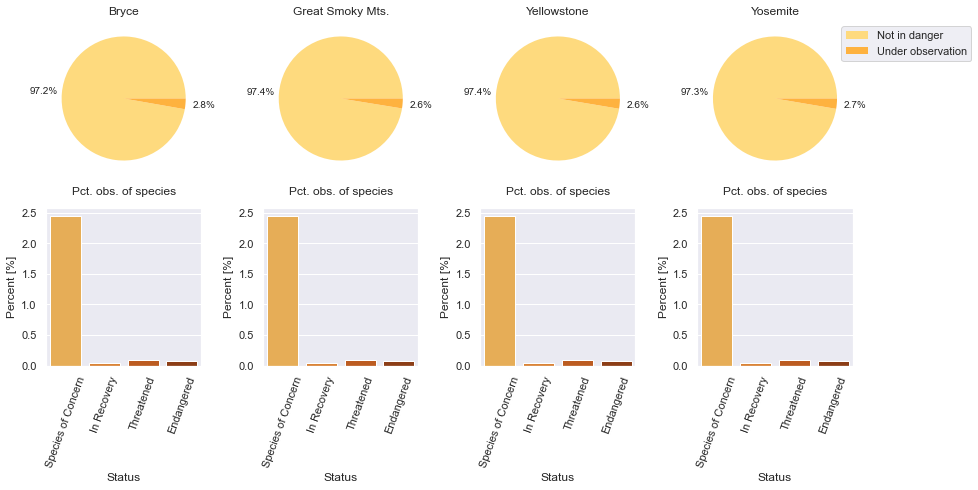

<Figure size 432x288 with 0 Axes>

In [36]:
conservation_df = data_nps.groupby(['park_name_short','conservation_status']).observations.sum().reset_index()
conservation_df['percent'] = conservation_df.apply(lambda row: round(row.observations*100/float(conservation_df[conservation_df.park_name_short == row.park_name_short].observations.sum()),2),axis=1)
conservation_df['in_danger'] = conservation_df.conservation_status.apply(lambda x: True if( str(x) != 'Not in danger' ) else False)
conservation_binary_df = conservation_df.groupby(['park_name_short','in_danger']).percent.sum().reset_index()
park_names = data_nps.park_name_short.unique()
list_conservation = list(conservation_df.conservation_status.unique())
list_conservation.pop(0)
index = 1
plt.figure(figsize=(14,6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.2)
for park in park_names:
    plt.subplot(2,len(park_names),index)
    ax = plt.pie(conservation_binary_df[conservation_binary_df.park_name_short == park].percent, normalize=True, wedgeprops = {'linewidth': 0}, colors=sns.color_palette("YlOrBr")[1:],autopct='%.1f%%', pctdistance=1.3)
    plt.title(park)
    index += 1
plt.legend(labels=['Not in danger','Under observation'],loc='upper right',bbox_to_anchor=(1.8, 1))

for park in park_names:
    plt.subplot(2,len(park_names),index)
    ax = sns.barplot(data=conservation_df[conservation_df.conservation_status != 'Not in danger'], x='conservation_status', y='percent', errorbar=None, order=list_conservation,palette=sns.color_palette("YlOrBr")[2:])
    ax.set_xticklabels(labels=list_conservation,rotation=70)
    plt.xlabel('Status')
    plt.ylabel('Percent [%]')
    plt.title('Pct. obs. of species', y=1.05)
    index += 1


plt.show()
plt.clf()

We can observe above that the percentage of the observations of species at each "conservation_status" is extremely similar in each national park.
In other words, when we normalize the observations in each park by the total number of observations in that park, we see that the fraction of species is almost the same in all parks for each conservation status label. The table below shows how the fraction is always 0.07 % for every park.

In [27]:
conservation_df[conservation_df.conservation_status=='Endangered']

,park_name_short,conservation_status,observations,percent,in_danger
4,Bryce,Endangered,402,0.07,True
9,Great Smoky Mts.,Endangered,294,0.07,True
14,Yellowstone,Endangered,1008,0.07,True
19,Yosemite,Endangered,616,0.07,True


### Question 4: Are the number of observations for a given species proportional to the total number of observations for that park or is there variability. 

0.01804728388377549


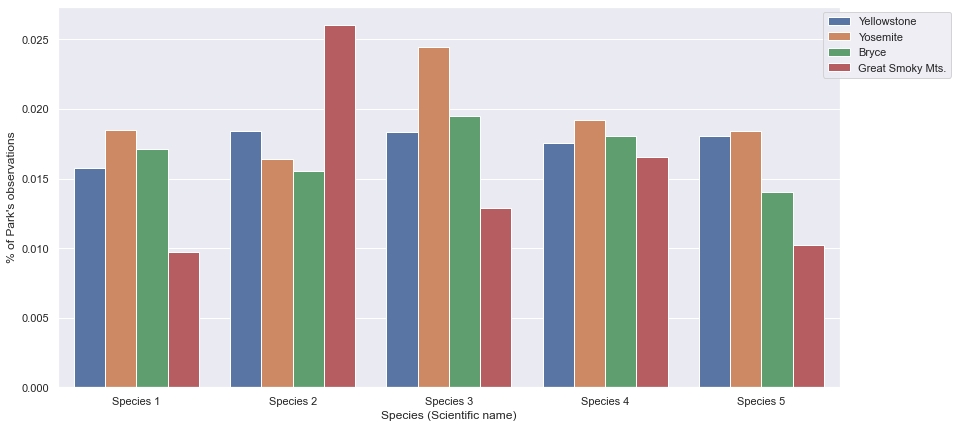

<Figure size 432x288 with 0 Axes>

In [28]:

total_obs = data_nps.groupby('park_name').observations.sum()
data_nps['pct_obs'] = data_nps.apply(lambda row: row.observations*100/float(total_obs[row.park_name]), axis=1)
print(data_nps.pct_obs.mean())

sample = data_nps.scientific_name.sample(n=5)
sample_df = data_nps[data_nps.scientific_name.isin(sample)].copy()
sample_df

labels = ['Species ' + str(i+1) for i in range(sample_df.scientific_name.nunique())]

plt.figure(figsize=(14,7))
ax = sns.barplot(data=sample_df, x='scientific_name', y='pct_obs', hue='park_name_short', hue_order=['Yellowstone', 'Yosemite', 'Bryce', 'Great Smoky Mts.'])
ax.set_xticklabels(labels=labels, rotation=0)
plt.legend(loc='upper right', bbox_to_anchor=(1.15,1))
plt.ylabel("% of Park's observations")
plt.xlabel('Species (Scientific name)')
plt.show()
plt.clf()


After observing the pattern above, we study each national park and test the hypothesis that: the species' observations/total observations of the park on average is 0.018 which is the mean of the full data. 

We choose a significance threshold of 0.05.

In [29]:
expected_mean = data_nps.pct_obs.mean()
pvals = []

sample_names = data_nps.scientific_name.sample(n=100)
sample_df = data_nps[data_nps.scientific_name.isin(sample_names)]
for park in park_names:
    tstat, pval = stats.ttest_1samp(sample_df[sample_df.park_name_short == park].pct_obs, expected_mean)
    pvals.append(pval)

print(pvals)

[0.3982614504960076, 0.7210509616917602, 0.4602501590733078, 0.01782984298743341]


We can conclude that since all p-values remain well above our significance threshold, the null hypothesis seems to hold. That is the number of observations in this data set seem to reflect the total number of observations of the national park, which is in turn well correlated with the size of the parks. We can witness this statement with the histogram below.

<Figure size 1008x504 with 0 Axes>

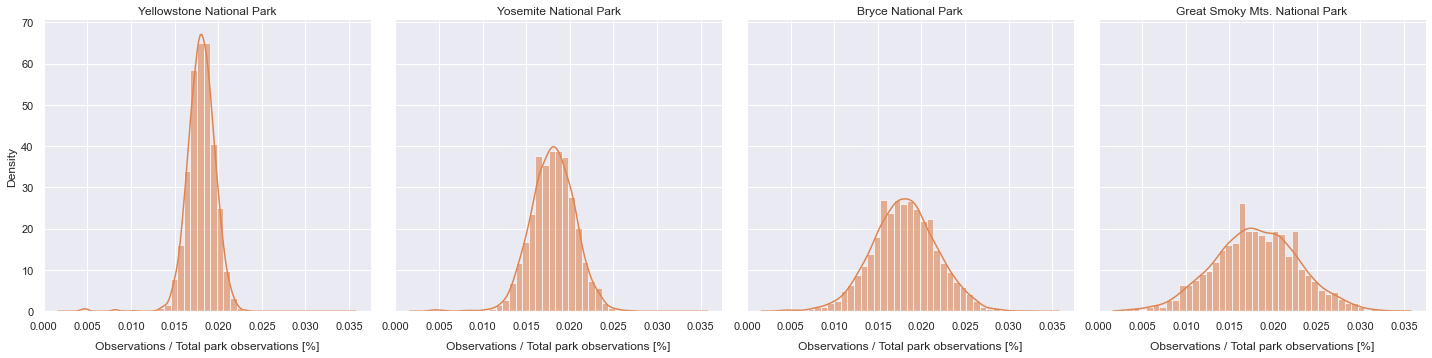

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure(figsize=(14,7))
g = sns.displot(data=data_nps, x='pct_obs', alpha=0.6, fill=True, kde=True, col='park_name_short', bins=45, color=sns.color_palette()[1], stat="density", col_order=park_list_by_obs)
g.set_titles("{col_name} National Park")
g.set_xlabels('Observations / Total park observations [%]', labelpad=10)
plt.show()
plt.clf()


We can also conclude, from the histograms above, how much variability there is in the observations in each national park. The histograms are ordered by descending amount of observations in each park from left to right.
- Yellowstone has a narrow distribution (low standard dev.) with some outliers towards the left, meaning there are a couple of species which had particularly low observations for that park, while almost all species are expected to be observed between 0.015% to 0.022% of the total observations for Yellowstone.
- The smaller the total number of observations, the wider the distribution. That is, the parks with less observations allow to observe a wider variety of species within a given amount of observations.

### Question 5: Which species are the most/least abundant in every national park, do they follow their conservation status?

In [31]:
min_df = pd.DataFrame(columns=data_nps.columns)
max_df = pd.DataFrame(columns=data_nps.columns)
for park in park_names:
    park_df = data_nps[data_nps.park_name_short == park]
    min_df = pd.concat([min_df, park_df[(park_df.observations == park_df.observations.min())]], ignore_index=True)
    max_df = pd.concat([max_df, park_df[(park_df.observations == park_df.observations.max())]], ignore_index=True)
    park_df2 = data_nps[(data_nps.park_name_short == park) & (data_nps.category != 'Vascular Plant')]
    min_df = pd.concat([min_df, park_df2[(park_df2.observations == park_df2.observations.min())]], ignore_index=True)
    max_df = pd.concat([max_df, park_df2[(park_df2.observations == park_df2.observations.max())]], ignore_index=True)

min_df.drop_duplicates(inplace=True)
max_df.drop_duplicates(inplace=True)

In [32]:
min_df.set_index('park_name')

,scientific_name,observations,category,conservation_status,park_name_short,pct_obs
park_name,,,,,,
Bryce National Park,Corydalis aurea,9,Vascular Plant,Not in danger,Bryce,0.001642
Bryce National Park,Vermivora bachmanii,20,Bird,Endangered,Bryce,0.003649
Great Smoky Mountains National Park,Collomia tinctoria,10,Vascular Plant,Not in danger,Great Smoky Mts.,0.002434
Great Smoky Mountains National Park,Rana sierrae,11,Amphibian,Endangered,Great Smoky Mts.,0.002678
Great Smoky Mountains National Park,Strix occidentalis,11,Bird,Not in danger,Great Smoky Mts.,0.002678
Yellowstone National Park,Grus americana,57,Bird,Endangered,Yellowstone,0.004150
Yosemite National Park,Noturus baileyi,31,Fish,Endangered,Yosemite,0.003774


In [33]:
max_df.set_index('park_name')

,scientific_name,observations,category,conservation_status,park_name_short,pct_obs
park_name,,,,,,
Bryce National Park,Valerianella radiata,176,Vascular Plant,Not in danger,Bryce,0.032107
Bryce National Park,Bubulcus ibis,164,Bird,Not in danger,Bryce,0.029918
Great Smoky Mountains National Park,Sonchus asper ssp. asper,147,Vascular Plant,Not in danger,Great Smoky Mts.,0.035782
Great Smoky Mountains National Park,Branta hutchinsii,139,Bird,Not in danger,Great Smoky Mts.,0.033834
Yellowstone National Park,Lycopodium tristachyum,321,Vascular Plant,Not in danger,Yellowstone,0.023370
Yellowstone National Park,Chrysemys picta bellii,307,Reptile,Not in danger,Yellowstone,0.022351
Yellowstone National Park,Pogonatum brachyphyllum,307,Nonvascular Plant,Not in danger,Yellowstone,0.022351
Yosemite National Park,Ivesia shockleyi var. shockleyi,223,Vascular Plant,Not in danger,Yosemite,0.027146
Yosemite National Park,Zygodon viridissimus var. rupestris,210,Nonvascular Plant,Not in danger,Yosemite,0.025564


Studying the most and least observed species, we can see that they are almost all Vascular plants and that only the least observed cases in `Yellowstone` and `Yosemite` have the `Endangered` label. 

Interestingly, these two endangered species are not vascular plants, but belong to the `Bird` and `Fish` categories. 

We ignore thereafter the `Vascular Plant` category and find out that indeed all species with the minimum amount of observations in each park is labeled as `Endangered`, while the maximally observed species are labeled `Not in danger`. This confirms somewhat our decision for the labels and its ranking. 

It will be interesting as well to dig in deeper and look for most and least observed species per category.

## Summary & Conclusions

The data is comprised of the observations of 5541 different species in four National Parks in the USA:
- Bryce National Park
- Great Smoky Mountains National Park
- Yellowstone National Park
- Yosemite National Park

The full data once properly cross-correlated with information on the species conservation status allows us to draw several observations. It is the case, that for the four parks the same set of species was focused. For each species there is information of the national park where it was seen and how many times it was observed. 

In order to obtain a clean data frame, we make the conservative assumption of ranking the conservation statuses from the least to the most concerning and we take the most concerning option whenever there was a duplicate. Additionally, to address several registries of observations of a given species in a national park we take the average number of observations because there is no timestamps to deduce any time information. 

We answered the following questions:

1. How is the distribution of species in the different national parks?
    
    The four parks seem to have very similar distributions of species. They present the same categories and the observations point at a correlation with the size of the park.
    The most abundant category is that of `Vascular Plant`, followed by `Bird`, then `Nonvascular Plant`, `Mammal`, `Fish` and lastly `Amphibian`. This is the case for each park.
    
2. Is any specific category of species more endangered than others?
    
    In terms of least number of total observations, `Vascular Plant` and `Mammal` are the categories with the most endangered species observed.
    In terms of variety of species, the `Mammal` category contains a larger number of different species labeled as `Endangered`. 
    It is worth mentioning that although the category `Vascular Plant` has a high number of endangered observations they belong to only 4 different species which are only abundant in relation to other categories. 
    
3. Are the populations of endangered species the same in all National Parks, are there any patterns?

    For all four parks around 2.7% of the observations belong to species with a conservation status of concern or higher. All parks present very similar fractions for each of the endangerment labels. 
    We have seen that exactly 0.07% of the observations in each park correspond to species that are `Endangered`.

4. Are the number of observations for a given species proportional to the total number of observations for that park or is there variability. 

    We suggest the hypothesis that the number of observations registered in the data correlate strongly with the size of the park because of the similarities observed in previous questions. 
    We have taken then random samples of species and their observations for each park and tested the hypothesis above. For all parks we obtain high p-values, far from a standard significance threshold of 0.05, which tells us that the data seems to be consistent with the hypothesis. 

5. Which species are the most/least abundant in every national park, do they follow their conservation status?

    We have studied tha maximum and minimum number of observations for the four National Parks and seen that again the category `Vascular Plant` needs to be considered on its own given the amount of observations. All the parks show that `Vascular Plant` is the most abundant category. Specifically we see the following vascular plants as the most abundant
        - Valerianella radiata	in Bryce
        - Sonchus asper ssp. asper in Great Smoky Mts.
        - Lycopodium tristachyum in Yellowstone
        - Ivesia shockleyi var. shockleyi in Yosemite

    and the following as the least abundant:
        - Corydalis aurea	in Bryce
        - Collomia tinctoria in Great Smoky Mts.

    none of which is in a status of concern or higher. Once the category of `Vascular Plant` is put aside we see a more diverse picture, where the most abundant species are:
        - Bubulcus ibis	(Bird) in Bryce
        - Branta hutchinsii	(Bird) in Great Smoky Mts.
        - Chrysemys picta bellii (Reptile) in Yellowstone
        - Zygodon viridissimus var. rupestris (Nonvascular Plant) in Yosemite

    all labeled as `Not in danger`. However, looking now at the least observed we have:
        - Vermivora bachmanii (Bird)
        - Rana sierrae (Amphibian)
        - Grus americana (Bird)	
        - Noturus baileyi (Fish)

    all labeled with `Endangered`. It is reasonable to state then that species that present low observations tend to be labeled as `Endangered`.

We have successfully answered the questions in the scope of the study and additionally found a somewhat linear correlation between the size of the park and the amount of observations within them. The distribution of fractional observations (observations/total park observations) are all centered around 0.018 with a standard deviation that decreases as the size of the park increases. 
